In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [18]:


import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import deeptrack as dt
import cv2
from deeptrack.extras import datasets
import os

datasets.load("ParticleTracking")

VIDEO_PATH_IDEAL = os.path.join(".", "datasets", "ParticleTracking", "ideal.avi")
VIDEO_PATH_BAD = os.path.join(".", "datasets", "ParticleTracking", "bad.avi")

IMAGE_SIZE = 120

ParticleTracking already downloaded! Use force_overwrite=True to redownload the dataset.


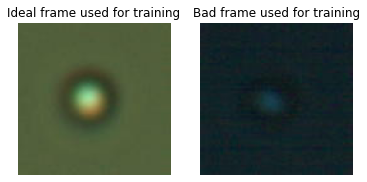

In [33]:
ideal_video_cap = cv2.VideoCapture(VIDEO_PATH_IDEAL)
bad_video_cap = cv2.VideoCapture(VIDEO_PATH_BAD)
bad_video_cap.read()
_, first_ideal_frame = ideal_video_cap.read()
_, first_bad_frame = bad_video_cap.read()

plt.subplot(1, 2, 1)
plt.imshow(first_ideal_frame)
plt.title("Ideal frame used for training")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(first_bad_frame)
plt.title("Bad frame used for training")
plt.axis("off")
plt.show()

In [34]:
ideal_image_value = dt.Value(first_ideal_frame)
bad_image_value = dt.Value(first_bad_frame)

image_loader = dt.OneOfDict({
    "ideal": ideal_image_value,
    "bad": bad_image_value
})

In [35]:
# Technically not needed, but good practice
image_augmenter = (
    dt.DummyFeature() >>
    dt.Gaussian(sigma=lambda:np.random.rand() * 0) >>
    dt.Add(lambda: np.random.randn() * 0.03)
)

In [36]:
image_normalizer = (
    dt.DummyFeature() >>
    skimage.color.rgb2gray >>
    (lambda x: cv2.resize(np.array(x), (IMAGE_SIZE,) * 2)[..., np.newaxis]) >>
    dt.NormalizeMinMax()    
)

In [37]:
training_dataset = image_loader >> image_augmenter >> image_normalizer

ideal_training_dataset = dt.Bind(training_dataset, key="ideal")
bad_training_dataset = dt.Bind(training_dataset, key="bad")


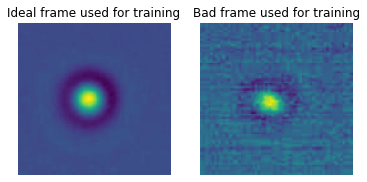

In [38]:
example_ideal_training_image = ideal_training_dataset.update()()
example_bad_training_image = bad_training_dataset.update()()

plt.subplot(1, 2, 1)
plt.imshow(example_ideal_training_image)
plt.title("Ideal frame used for training")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(example_bad_training_image)
plt.title("Bad frame used for training")
plt.axis("off")
plt.show()

In [39]:
model_trained_on_bad_data = dt.models.AutoTracker(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    mode="tracking",
)
model_trained_on_ideal_data = dt.models.AutoTracker(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    mode="tracking",
)

model_trained_on_bad_data.fit(bad_training_dataset, batch_size=8, epochs=40)
# model_trained_on_ideal_data.fit(ideal_training_dataset, batch_size=8, epochs=20)

Generating 179 / 160 samples before starting training
Epoch 1/40
179/179 [==============================] - 4s 12ms/step - loss: 2.2545 - consistency_loss: 4.7255
Epoch 2/40
179/179 [==============================] - 2s 11ms/step - loss: 2.0403 - consistency_loss: 4.6789
Epoch 3/40
179/179 [==============================] - 2s 11ms/step - loss: 2.0616 - consistency_loss: 4.1261
Epoch 4/40
179/179 [==============================] - 2s 11ms/step - loss: 1.7461 - consistency_loss: 2.0172
Epoch 5/40
179/179 [==============================] - 2s 12ms/step - loss: 0.5173 - consistency_loss: 0.2689
Epoch 6/40
179/179 [==============================] - 2s 11ms/step - loss: 0.4400 - consistency_loss: 0.1417
Epoch 7/40
179/179 [==============================] - 2s 11ms/step - loss: 0.1567 - consistency_loss: 0.0432
Epoch 8/40
179/179 [==============================] - 2s 11ms/step - loss: 0.1155 - consistency_loss: 0.0293
Epoch 9/40
179/179 [==============================] - 2s 11ms/step - loss:

In [10]:
ideal_frame_count = int(ideal_video_cap.get(7))
ideal_video = np.zeros((ideal_frame_count, IMAGE_SIZE, IMAGE_SIZE, 1))
ideal_video_cap.set(1, 0)
for idx in range(ideal_frame_count):
    _, frame = ideal_video_cap.read()
    ideal_video[idx, ...] = image_normalizer(frame)

In [28]:
bad_frame_count = int(ideal_video_cap.get(7))
bad_video = np.zeros((ideal_frame_count, IMAGE_SIZE, IMAGE_SIZE, 1))
bad_video_cap.set(1, 0)
for idx in range(bad_frame_count):
    _, frame = bad_video_cap.read()
    bad_video[idx, ...] = image_normalizer(frame)

In [40]:
# ideal_video_pred_by_ideal_model = model_trained_on_ideal_data.predict(ideal_video)
# ideal_video_pred_by_bad_model = model_trained_on_bad_data.predict(ideal_video)
# bad_video_pred_by_ideal_model = model_trained_on_ideal_data.predict(bad_video)
bad_video_pred_by_bad_model = model_trained_on_bad_data.predict(bad_video)

In [13]:
# frames_to_show = 200

# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(ideal_video_pred_by_ideal_model[:frames_to_show, 0])
# plt.plot(ideal_video_pred_by_bad_model[:frames_to_show, 0])
# plt.legend(["Model trained on ideal", "Model trained on bad"])

# plt.subplot(1, 2, 2)
# plt.plot(ideal_video_pred_by_ideal_model[:frames_to_show, 0])
# plt.plot(ideal_video_pred_by_bad_model[:frames_to_show, 0])
# plt.legend(["Model trained on ideal", "Model trained on bad"])
# plt.show()

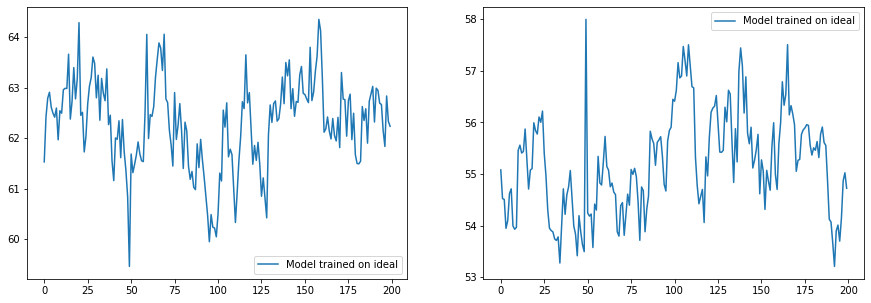

In [41]:
frames_to_show = 200

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
# plt.plot(bad_video_pred_by_ideal_model[:frames_to_show, 0])
plt.plot(bad_video_pred_by_bad_model[:frames_to_show, 0])
plt.legend(["Model trained on ideal", "Model trained on bad"])

plt.subplot(1, 2, 2)
# plt.plot(bad_video_pred_by_ideal_model[:frames_to_show, 0])
plt.plot(bad_video_pred_by_bad_model[:frames_to_show, 1])
plt.legend(["Model trained on ideal", "Model trained on bad"])
plt.show()

In [43]:
np.save("bad_pred", bad_video_pred_by_bad_model[:50])

In [15]:
def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta = x[1 + delt :] - x[: -(1 + delt)]
        squared_displacement = np.square(delta).sum(axis=-1)

        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                len(squared_displacement),
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

In [16]:
plt.plot(get_msd(ideal_video_pred_by_ideal_model, 100)[:, 0])
plt.plot(get_msd(ideal_video_pred_by_bad_model, 100)[:, 0])
plt.show()

NameError: name 'ideal_video_pred_by_ideal_model' is not defined

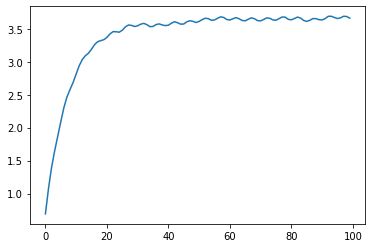

In [42]:
# plt.plot(get_msd(bad_video_pred_by_ideal_model, 100)[:, 0])
plt.plot(get_msd(bad_video_pred_by_bad_model, 100)[:, 0])
plt.show()